# Quick introduction


First we need to instantiate the `ERDDAP` URL constructor for a server.
In this example we will use [https://data.ioos.us/gliders/erddap](https://data.ioos.us/gliders/erddap).

In [1]:
from erddapy import ERDDAP


server_url = 'https://data.ioos.us/gliders/erddap'

e = ERDDAP(server_url=server_url)

What are the methods/attributes available?

In [2]:
[method for method in dir(e) if not method.startswith('_')]

['download_options',
 'get_download_url',
 'get_info_url',
 'get_opendap_url',
 'get_search_url',
 'get_var_by_attr',
 'search_options',
 'server_url']

All the `get_<methods>` will return a valid `ERDDAP` URL for the requested response and options.
`erddapy` will raise an error is if URL HEADER cannot be validated.

In [3]:
print(e.get_search_url(response='.html', search_for='all'))

https://data.ioos.us/gliders/erddap/search/advanced.html?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=(ANY)&maxTime=(ANY)&searchFor=all


There are many responses available, see the docs for [griddap](http://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html) and
[tabledap](http://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html) respectively.
The most useful ones for Pythonistas are the `.csv` and `.nc` that can be read with pandas and netCDF4-python respectively.

Let's load the `csv` reponse directly with `pandas`.

In [4]:
import pandas as pd


df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))

In [5]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 291 tabledap, 0 griddap, and 0 wms endpoints.'

We can refine our search by providing some constraints.

In [6]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

Let's narrow the search area, time span, and look for `sea_water_temperature` only.

In [7]:
import pendulum

min_time = pendulum.parse('2016-07-10T00:00:00Z')
max_time = pendulum.parse('2017-02-10T00:00:00Z')

min_lat, max_lat =  38.0, 41.0
min_lon, max_lon = -72.0, -69.0

standard_name = 'sea_water_temperature'

In [8]:
kw = {
    'standard_name': standard_name,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectoryprofile'
}

search_url = e.get_search_url(response='html', **kw)

show_iframe(search_url)

search_url = e.get_search_url(response='html', **kw)

show_iframe(search_url)

We can see that the search form above was correctly populated with the constraints we provided.

Let us change the response from `.html` to `.csv`,
so we load it as a `pandas.DataFrame`,
and inspect what are the `Dataset ID`s available for download.

Note that the optional constraints are kept in a `dict`,
making if easy to reuse, update or just inspect what where the original parameters used.

In [9]:
e.search_options

{'cdm_data_type': 'trajectoryprofile',
 'institution': '(ANY)',
 'ioos_category': '(ANY)',
 'itemsPerPage': 1000,
 'keywords': '(ANY)',
 'long_name': '(ANY)',
 'maxLat': 41.0,
 'maxLon': -69.0,
 'maxTime': 1486684800.0,
 'minLat': 38.0,
 'minLon': -72.0,
 'minTime': 1468108800.0,
 'page': 1,
 'protocol': '(ANY)',
 'response': 'html',
 'searchFor': None,
 'server_url': 'https://data.ioos.us/gliders/erddap',
 'standard_name': 'sea_water_temperature',
 'variableName': '(ANY)'}

In [10]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 5 Glider Datasets:
blue-20160818T1448
cp_336-20170116T1254
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Now that we know the `Dataset ID`s we can explore their metadata with the `get_info_url` method.

In [11]:
info_url = e.get_info_url(dataset_id=gliders[0], response='html')

show_iframe(src=info_url)

Again, with the `csv` response, we can manipulate the metadata and find the variables that have the `cdm_profile_variables` attribute.

In [12]:
info_url = e.get_info_url(dataset_id=gliders[0], response='csv')

info = pd.read_csv(info_url)

info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgement,String,This deployment supported by NOAA U.S. IOOS
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider deployed by the University of Massachus...


In [13]:
''.join(info.loc[info['Attribute Name'] == 'cdm_profile_variables', 'Value'])

'profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v'

Selecting variables by theirs attributes is such a common operation that `erddapy` brings its own method to simplify this task.

The `get_var_by_attr` method is inspired by `netCDF4-python`'s `get_variables_by_attributes` however, because `erddapy` is operating on remote serves, it will return the variable names instead of the actual variables.

Here we check what is/are the variable(s) associated with the `standard_name` used in the search.

Note that `get_var_by_attr` caches the last response in case the user needs to make multiple requests,
but it will loose its state when a new request is made.

(See the execution times below.)

In [14]:
%%time

# First one, slow.
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_temperature'
)

CPU times: user 166 ms, sys: 7.99 ms, total: 174 ms
Wall time: 1.8 s


['temperature']

In [15]:
%%time

# Second one on the same glider, fast.
e.get_var_by_attr(
    dataset_id='blue-20160818T1448',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 19.1 ms, sys: 12.5 ms, total: 31.6 ms
Wall time: 787 ms


['salinity']

In [16]:
%%time

# New one, slow.
e.get_var_by_attr(
    dataset_id='cp_336-20170116T1254',
    standard_name='sea_water_practical_salinity'
)

CPU times: user 174 ms, sys: 7.3 ms, total: 181 ms
Wall time: 1.77 s


['salinity']

With Python it is easy to loop over all the `dataset_id`s for the variables with `standard_names`

In [17]:
variables = [e.get_var_by_attr(dataset_id=glider, standard_name=lambda v: v is not None) for glider in gliders]

We can construct a `set` with the common variables in those `dataset_id`s.

In [18]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables

{'conductivity',
 'conductivity_qc',
 'density',
 'density_qc',
 'depth',
 'depth_qc',
 'lat_uv',
 'lat_uv_qc',
 'latitude',
 'latitude_qc',
 'lon_uv',
 'lon_uv_qc',
 'longitude',
 'longitude_qc',
 'precise_lat',
 'precise_lon',
 'precise_time',
 'precise_time_qc',
 'pressure',
 'pressure_qc',
 'salinity',
 'salinity_qc',
 'temperature',
 'temperature_qc',
 'time',
 'time_qc',
 'time_uv',
 'time_uv_qc',
 'u',
 'u_qc',
 'v',
 'v_qc'}

Last, but not least, the download endpoint!

It is important to note that the download constraints are based on the variables names and not the standardized ones for the `get_search_url` method.

In [19]:
kwargs = {
    'time>=': min_time,
    'time<=': max_time,
    'latitude>=': min_lat,
    'latitude<=': max_lat,
    'longitude>=': min_lon,
    'longitude<=': max_lon,
}


download_url = e.get_download_url(dataset_id=gliders[0], variables=common_variables, response='html', **kwargs)

download_url

'https://data.ioos.us/gliders/erddap/tabledap/blue-20160818T1448.html?precise_lon,pressure_qc,v_qc,depth,density,density_qc,time_uv,depth_qc,conductivity_qc,temperature_qc,latitude_qc,precise_time_qc,lon_uv,time_uv_qc,u,lon_uv_qc,longitude_qc,salinity,u_qc,longitude,pressure,temperature,lat_uv,v,time,salinity_qc,precise_time,conductivity,time_qc,lat_uv_qc,latitude,precise_lat&time>=2016-07-10T00:00:00+00:00&time<=2017-02-10T00:00:00+00:00&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

In [20]:
e.download_options

{'latitude<=': 41.0,
 'latitude>=': 38.0,
 'longitude<=': -69.0,
 'longitude>=': -72.0,
 'time<=': <Pendulum [2017-02-10T00:00:00+00:00]>,
 'time>=': <Pendulum [2016-07-10T00:00:00+00:00]>}

Putting everything in `DataFrame`s.

In [21]:
from requests.exceptions import HTTPError


def download_csv(url):
    return pd.read_csv(url, index_col='time', parse_dates=True, skiprows=[1])


dfs = {}
for glider in gliders:
    try:
        download_url = e.get_download_url(dataset_id=glider, variables=common_variables, response='csv', **kwargs)
    except HTTPError:
        print('Failed to download {}'.format(glider))
        continue
    dfs.update({glider: download_csv(download_url)})

Failed to download silbo-20160413T1534
Failed to download sp022-20170209T1616


It is unclear to me why `ERDDAP` found two datasets with the constraints provided but failed to generate an URL for the download.

In [22]:
try:
    e.get_download_url(
        dataset_id='silbo-20160413T1534',
        variables=common_variables,
        response='csv',
        **kwargs
    )
except Exception as err:
    print(err)

500 Server Error: Internal Server Error for url: https://data.ioos.us/gliders/erddap/tabledap/silbo-20160413T1534.csv?precise_lon,pressure_qc,v_qc,depth,density,density_qc,time_uv,depth_qc,conductivity_qc,temperature_qc,latitude_qc,precise_time_qc,lon_uv,time_uv_qc,u,lon_uv_qc,longitude_qc,salinity,u_qc,longitude,pressure,temperature,lat_uv,v,time,salinity_qc,precise_time,conductivity,time_qc,lat_uv_qc,latitude,precise_lat&time%3E=2016-07-10T00:00:00+00:00&time%3C=2017-02-10T00:00:00+00:00&latitude%3E=38.0&latitude%3C=41.0&longitude%3E=-72.0&longitude%3C=-69.0


The glider datasets should be masked automatically but we found that is not true.
The cell below applies the mask as described by the data QC flag.

In [23]:
import numpy as np


for glider in dfs.keys():
    dfs[glider].loc[dfs[glider]['salinity_qc'] == 9, 'salinity'] = np.NaN
    dfs[glider].loc[dfs[glider]['pressure_qc'] == 9, 'pressure'] = np.NaN
    dfs[glider].loc[dfs[glider]['temperature_qc'] == 9, 'temperature'] = np.NaN
    dfs[glider].loc[dfs[glider]['salinity'] <= 0, 'salinity'] = np.NaN

Finally let's see some figures!

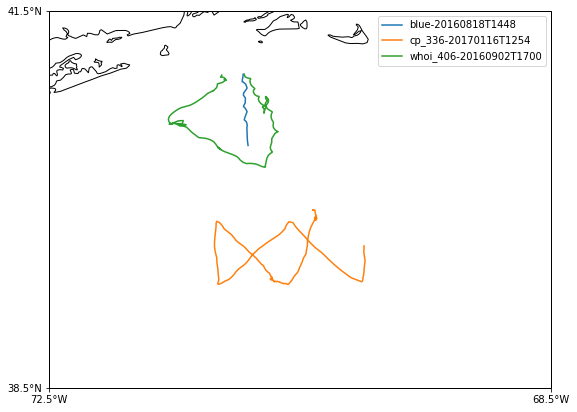

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(extent):
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution='10m')
    ax.set_extent(extent)

    ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
    ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


dx = dy = 0.5
extent = min_lon-dx, max_lon+dx, min_lat+dy, max_lat+dy

fig, ax = make_map(extent)
for glider, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=glider)

leg = ax.legend()

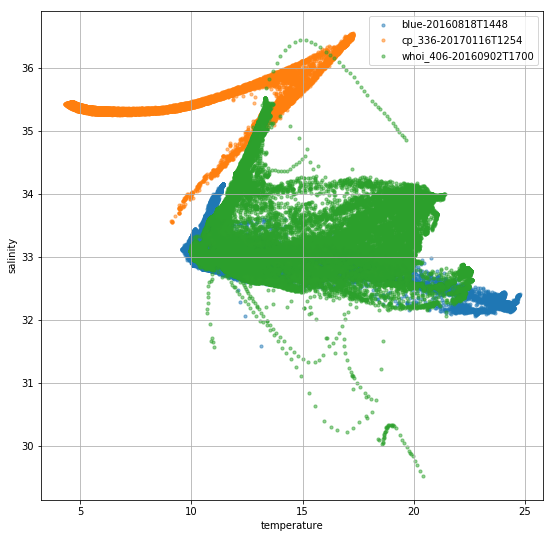

In [25]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)

leg = ax.legend()

## Extras

### OPeNDAP response

In [26]:
from netCDF4 import Dataset

opendap_url = e.get_opendap_url('cp_336-20170116T1254')
print('Getting data from {}\n'.format(opendap_url))
with Dataset(opendap_url) as nc:
    print(nc.summary)

Getting data from https://data.ioos.us/gliders/erddap/tabledap/cp_336-20170116T1254

The Pioneer Array is located off the coast of New England, south of Martha's Vineyard. The Continental Shelf-Slope area off the New England coast is a highly productive area and one that is located at a dynamic intersection where ocean currents meet in weather-like 'fronts', and where nutrients, pollutants, and other properties are exchanged between the coast and the deep ocean. Data from the inshore, shelf area helps to examine exchanges between the shelf and slope and the shelf ecosystem, as well as provide broader insight into the issues of air-sea gas exchange, including Carbon Dioxide. In order to provide synoptic, multi-scale observations of the outer continental shelf, shelf break region, and continental slope, the moored portion of the Pioneer Array is supplemented by six Coastal Gliders. The role of the Coastal Gliders is to monitor the mesoscale field of the slope sea and outer shelf, resolvi

### netCDF "file-like" to xarray

`open_dataset` will download a temporary file,
so be careful with the constraints to avoid downloading several gigabytes!

In [27]:
import requests


def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    k = 0
    while nbytes >= 1024 and k < len(suffixes)-1:
        nbytes /= 1024.
        k += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[k])

r = requests.head(download_url)
nbytes = float(r.headers['Content-Length'])
humansize(nbytes)

'2.1 MB'

That is the uncompressed size, we are OK because the download will be less than that, `ERDDAP` streams gzip'ed data.

In [28]:
r.headers['Content-Encoding']

'gzip'

In [29]:
from erddapy import open_dataset

download_url = e.get_download_url(
    dataset_id='cp_336-20170116T1254',
    response='nc',
    variables=common_variables,
    **kwargs,
)

ds = open_dataset(
    download_url,
)

ds

<xarray.Dataset>
Dimensions:          (row: 16232)
Coordinates:
    depth            (row) float64 ...
    time_uv          (row) datetime64[ns] ...
    lon_uv           (row) float64 ...
    longitude        (row) float64 ...
    lat_uv           (row) float64 ...
    time             (row) datetime64[ns] ...
    latitude         (row) float64 ...
Dimensions without coordinates: row
Data variables:
    precise_lon      (row) float64 ...
    pressure_qc      (row) float64 ...
    v_qc             (row) float64 ...
    density          (row) float64 ...
    density_qc       (row) float64 ...
    depth_qc         (row) float64 ...
    conductivity_qc  (row) float64 ...
    temperature_qc   (row) float64 ...
    latitude_qc      (row) float64 ...
    precise_time_qc  (row) float64 ...
    time_uv_qc       (row) float64 ...
    u                (row) float64 ...
    lon_uv_qc        (row) float64 ...
    longitude_qc     (row) float64 ...
    salinity         (row) float64 ...
    u_qc    

In [30]:
ds['temperature']

<xarray.DataArray 'temperature' (row: 16232)>
array([14.3976, 14.4236, 14.4596, ...,  4.4004,  4.3975,  4.3978])
Coordinates:
    depth      (row) float64 ...
    time_uv    (row) datetime64[ns] ...
    lon_uv     (row) float64 ...
    longitude  (row) float64 ...
    lat_uv     (row) float64 ...
    time       (row) datetime64[ns] ...
    latitude   (row) float64 ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          1
    actual_range:         [ 0.     17.2652]
    ancillary_variables:  temperature_qc
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    source_variable:      sci_water_temp
    standard_name:        sea_water_temperature
    units:                degree_Celsius
    valid_max:            40.0
    valid_min:            -5.0

In [31]:
data = ds['temperature'].values
depth = ds['depth'].values

mask = ~np.ma.masked_invalid(data).mask

In [32]:
data = data[mask]
depth = depth[mask]
lon = ds['longitude'].values[mask]
lat = ds['latitude'].values[mask]

In [33]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mask = depth <= 5

data = data[mask]
depth = depth[mask]
lon = lon[mask]
lat = lat[mask]

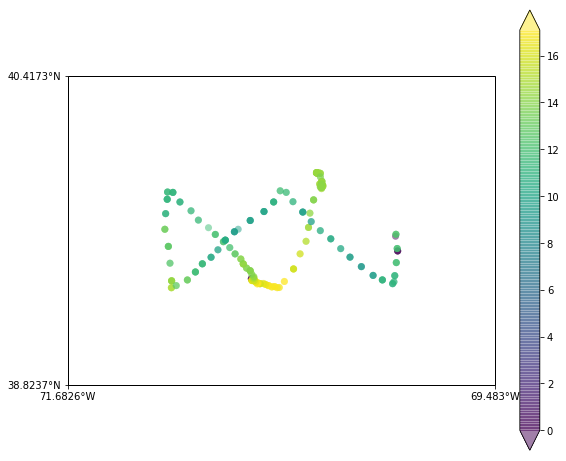

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


extent = (
    ds.geospatial_lon_min-dx, ds.geospatial_lon_max+dx,
    ds.geospatial_lat_min-dy, ds.geospatial_lat_max+dy
)
fig, ax = make_map(extent)

cs = ax.scatter(lon, lat, c=data, s=50, alpha=0.5, edgecolor='none')
kw = dict(orientation='vertical', fraction=0.1,
          shrink=0.9, extend='both')
cbar = fig.colorbar(cs, **kw)